In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


import acgan
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import twodlearn as tdl
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import reduce
import matplotlib.pyplot as plt
BATCH_SIZE = 64
#acgan.data.DATA_DIR = '/data/marinodl/tensorflow_datasets'
session = tf.InteractiveSession()


In [2]:
#dataset = acgan.data.load_celeb_a(BATCH_SIZE)
dataset = acgan.data.load_mnist32(BATCH_SIZE)
input_shape = dataset.output_shapes.as_list()
print('input shape: {}'.format(input_shape))

Instructions for updating:
Colocations handled automatically by placer.


W0331 06:54:02.404372 140295338723136 deprecation.py:323] From /home/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


input shape: [None, 32, 32, 1]


In [3]:
model = acgan.model.MSG_GAN(
    embedding_size=100,
    generator={'init_shape':(4, 4, 264),
               'units': [128, 64, 1],
               'kernels': 3,
               'strides': [2, 2, 2],
               'padding': ['same', 'same', 'same', 'same']},
    discriminator={'units':[64, 128, 264],
                   'kernels':3,
                   'strides':[2, 2, 2],
                   'dropout':None}
)
#model.noise_rate.init(rate=0.001)
print('output shape: {}'.format(
    model.generator.compute_output_shape(
        input_shape=[None, 100])))

output shape: (?, 32, 32, 1)


In [4]:
iter = dataset.make_one_shot_iterator()
xreal = iter.get_next()

import twodlearn.debug
@tdl.debug.stop_at_error
def _test():
    gen = model.generator_trainer(BATCH_SIZE, learning_rate=0.0002)
    dis = model.discriminator_trainer(BATCH_SIZE, xreal=xreal, learning_rate=0.0002)
    return gen, dis
gen, dis = _test()
tdl.core.variables_initializer(gen.variables).run()
tdl.core.variables_initializer(dis.variables).run()

Instructions for updating:
Use tf.cast instead.


W0331 06:54:03.191856 140295338723136 deprecation.py:323] From /home/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


W0331 06:54:03.457538 140295338723136 deprecation.py:323] From /home/marinodl/research/2019/AssociativeGAN/env/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


In [5]:
model.discriminator.hidden_shapes

[TensorShape([Dimension(64), Dimension(16), Dimension(16), Dimension(64)]),
 TensorShape([Dimension(64), Dimension(8), Dimension(8), Dimension(128)]),
 TensorShape([Dimension(64), Dimension(4), Dimension(4), Dimension(264)])]

In [6]:
model.discriminator.projections

In [7]:
model.discriminator.layers

In [8]:
model.generator.pyramid_shapes

[TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(264)]),
 TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(128)]),
 TensorShape([Dimension(None), Dimension(16), Dimension(16), Dimension(64)]),
 TensorShape([Dimension(None), Dimension(32), Dimension(32), Dimension(1)])]

In [9]:
model.generator.layers[-1].units

1

In [10]:
dis.xreal.shape.as_list()

[None, 32, 32, 1]

In [11]:
print('step {} | dis {} | gen {}'.format(dis.train_step.eval(), dis.loss.eval(), gen.loss.eval()) )

step 0 | dis 0.6883189082145691 | gen 0.6956252455711365


In [45]:
acgan.train.run_training(dis=dis, gen=gen, n_steps=500, n_logging=10)

step 2875 | dis 0.6544 | gen 0.6463 : : 1002it [00:40, 24.49it/s]


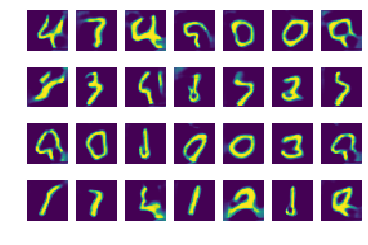

In [46]:
xsim = dis.xsim.eval()
for i in range(4*7):
    plt.subplot(4,7, i+1)
    plt.imshow(np.squeeze((xsim[i][:,:,:]+1)*0.5))
    plt.axis('off')

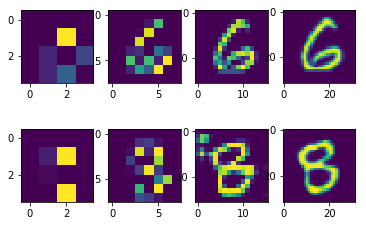

In [52]:
fig, ax = plt.subplots(2, len(dis.real_pyramid))
real_pyramid_ = session.run(dis.real_pyramid)
sim_pyramid_ = session.run(gen.sim_pyramid)
for idx in range(len(dis.real_pyramid)):
    ax[0, idx].imshow(np.squeeze(real_pyramid_[idx][1, ...]+1)*0.5)
    ax[1, idx].imshow(np.squeeze(sim_pyramid_[idx][1, ...]+1)*0.5)